In [1]:
import logging

# logging.basicConfig(
#     level=logging.DEBUG,
#     format='%(asctime)s - %(levelname)s - %(message)s'
# )

logger = logging.getLogger("dicris")
logger.setLevel(logging.DEBUG)

# Create handlers
console_handler = logging.StreamHandler()
file_handler = logging.FileHandler("dicris.log")

# Set levels for handlers
console_handler.setLevel(logging.DEBUG)
file_handler.setLevel(logging.DEBUG)

# Create formatters and add to handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)

# Add handlers to logger
logger.addHandler(console_handler)
# logger.addHandler(file_handler)

import contextily as ctx
import geemap
import geocube
import geopandas as gpd
import io
import json
import keras
import laspy
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import pathlib
import rasterio
import re
import seaborn as sns
import shapely
import spectral
import tempfile
import tensorflow as tf
import zipfile

from affine import Affine
from functools import partial
from geocube.api.core import make_geocube
from IPython.display import JSON, HTML
from keras.utils import to_categorical
from matplotlib.colors import to_rgba
from mpl_toolkits.mplot3d import Axes3D
from pyproj import CRS
from rasterio.io import MemoryFile
from shapely.affinity import affine_transform
from shapely.geometry import box, mapping, Point, Polygon
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from spectral import envi
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm

# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

/usr/local/lib/python3.11/dist-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-05-30 13:01:59.446087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748610119.461421   18318 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748610119.466068   18318 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748610119.478910   18318 computation_placer.cc:177] computation placer already registered. Ple

In [2]:
class Classification:
    """
    Represents classification codes and their corresponding Slovak descriptions for LAS data.
    """
    LABELS = {
        0: "mimo klasifikácie",
        1: "neklasifikované",
        2: "zem",
        3: "výška vegetacie od 1 do 3 m",
        4: "výška vegetacie od 3 do 5 m",
        5: "výška vegetacie od 5 m a viac",
        6: "budovy",
        9: "voda",
        10: "auto",
        16: "vodič",
        17: "stožiar",
        20: "zemné lano",
        30: "železnica",
        31: "cesta",
    }

    @classmethod
    def get_label(cls, code):
        """
        Returns the label associated with a classification code.

        Parameters:
            code (int): The classification code.

        Returns:
            str: The corresponding label, or "Unknown" if the code is not defined.
        """
        return cls.LABELS.get(code, "Unknown")


def find_las_files(dir):
    files = [f for f in pathlib.Path(dir).rglob('*') if f.suffix.lower().endswith(('.las'))]
    files = sorted(files, key=lambda k: k.as_posix().lower())
    return files


def sample_las(las, p=0.3):
    """
    Randomly sample a fraction of points from a LAS point cloud.

    This function creates a new LAS object containing a random subset of points 
    from the input LAS data. The sampling is done without replacement.

    Parameters:
        las (laspy.LasData): Input LAS point cloud data.
        p (float, optional): Fraction of total points to sample (default is 0.3).

    Returns:
        laspy.LasData: A new LAS data object containing the sampled points.

    Raises:
        ValueError: If the fraction p is not in the range (0, 1].
    """
    total_points = len(las.points)
    n = int(p * total_points)
    indices = np.random.choice(total_points, size=n, replace=False)
    sampled_points = las.points[indices]
    new_las = laspy.LasData(las.header)
    new_las.points = sampled_points
    return new_las


def display_las(las, class_name='z', title=None):
    """
    Display LAS point cloud data in a 3D scatter plot.

    Parameters:
        las (laspy.LasData): LAS data object to visualize.
    """
    x = las.x
    y = las.y
    z = las.z
    c = las[class_name]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=c, cmap='viridis', s=0.1)

    # produce a legend
    if class_name.lower() == 'classification':
        handles, labels = scatter.legend_elements()
        # Extract number from LaTeX-like formatted labels (e.g., '$\\mathdefault{2}$')
        def extract_numeric_label(label):
            match = re.search(r'\{(\d+)\}', label)
            return int(match.group(1)) if match else label
        cleaned_labels = [Classification.LABELS.get(extract_numeric_label(label), label) for label in labels]
        legend = ax.legend(handles, cleaned_labels, loc="lower left", title=class_name)
        ax.add_artist(legend)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def log_las_header(las_header: laspy.LasHeader, level=logging.INFO):
    """
    Logs header information from a LAS file.

    Parameters:
        las (laspy.LasData): LAS data object.

    Returns:
        None
    """
    logger.log(
        level,
        "LAS Header Info:\n"
        "X Max: %f\nY Max: %f\n"
        "X Min: %f\nY Min: %f\n"
        "X Offset: %f\nY Offset: %f\n"
        "X Scale: %f\nY Scale: %f",
        las_header.x_max,
        las_header.y_max,
        las_header.x_min,
        las_header.y_min,
        las_header.x_offset,
        las_header.y_offset,
        las_header.x_scale,
        las_header.y_scale
    )


def get_geographic_bounds_from_las_header(las_header: laspy.LasHeader) -> tuple:
    """
    Extract the geographic bounding box from LAS data.

    Parameters:
        las (laspy.LasData): LAS point cloud data object.

    Returns:
        tuple: A tuple (xmin, ymin, xmax, ymax) representing the spatial extent of the point cloud.
    """
    return (
        las_header.x_min,
        las_header.y_min,
        las_header.x_max,
        las_header.y_max
    )

def get_gdf_from_bounds(bounds: tuple, crs=None) -> gpd.GeoDataFrame:
    """
    Create a GeoDataFrame from bounding box coordinates.

    Parameters:
        bounds (tuple): A tuple (xmin, ymin, xmax, ymax) representing a bounding box.
        crs (str or CRS, optional): Coordinate reference system to assign to the GeoDataFrame.

    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame with a single polygon geometry for the bounding box.
    """
    geometry = box(*bounds)
    gdf = gpd.GeoDataFrame({'geometry': [geometry]}, crs=crs)
    return gdf


def scale_bbox(bbox, scale=1.0, fixed_ratio=True):
    w = np.abs(bbox[2] - bbox[0])
    h = np.abs(bbox[3] - bbox[1])
    dw = (scale * w - w) / 2
    dh = (scale * h - h) / 2
    if fixed_ratio:
        dw = np.max([dw, dh])
        dh = dw
    x_min= bbox[0] - dw
    x_max= bbox[2] + dw
    y_min= bbox[1] - dh
    y_max= bbox[3] + dh
    return (x_min, y_min, x_max, y_max)


def set_axes_limits(ax, xlim_min, ylim_min, xlim_max, ylim_max):
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)


def plot_gdf(
    gdf: gpd.GeoDataFrame,
    title=None,
    figsize=(20,12),
    basemap=True,
    ax=None
):
    if ax == None:
        _, ax = plt.subplots(1, figsize=figsize)
    ax = gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
    if basemap:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=gdf.crs)
    if title != None:
        ax.set_title(title)
    if basemap:
        plt.show()
    return ax


def get_gdf_from_las_header(
    las_header: laspy.LasHeader,
    crs=None
) -> gpd.GeoDataFrame:
    if crs == None:
        crs = las_header.parse_crs()    
    bbox = get_geographic_bounds_from_las_header(las_header)
    gdf = get_gdf_from_bounds(bbox, crs=crs)
    return gdf

def plot_las_bounds(
    las_header,
    crs=None,
    scale=1.0,
    fixed_ratio=True,
    figsize=(20,12),
    **kws
):
    gdf = get_gdf_from_las_header(las_header, crs=crs)
    f, ax = plt.subplots(1, figsize=figsize)
    # zoom out -> scale bbox
    set_axes_limits(
        ax,
        *scale_bbox(
            gdf.bounds.to_numpy()[0],
            scale=scale
        )
    )    
    return plot_gdf(gdf, ax=ax, figsize=figsize, **kws)

## find .las files

In [3]:
data_dir = os.path.join('/tf/notebooks/data/Hyperspektral_data/HYSPED/')
las_files = find_las_files(data_dir)
logger.info(f'las files found: {len(las_files)}')

2025-05-30 13:02:09,259 - dicris - INFO - las files found: 50


## load selected .las file

In [4]:
las_file = las_files[0]
las = laspy.read(las_file)
logger.info(f'las.header.point_format: {las.header.point_format}')

2025-05-30 13:02:17,401 - dicris - INFO - las.header.point_format: <PointFormat(1, 0 bytes of extra dims)>


## randomly sample % points of the loaded .las file

In [5]:
las_sampled = sample_las(las, 0.05)

## display sampled data

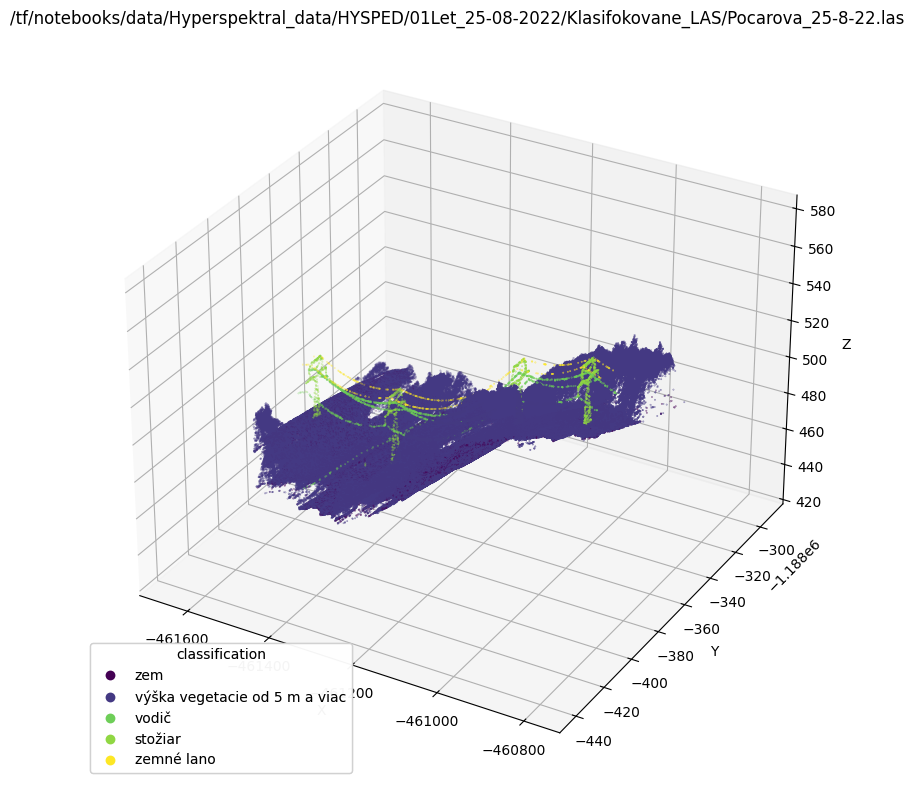

In [6]:
display_las(
    las_sampled,
    class_name='classification',
    title=las_file
)

## interactive 3D preview

In [7]:
temp_f = tempfile.NamedTemporaryFile(mode='wb', delete=False, suffix='.las')
las_sampled.write(temp_f)
temp_f.close()
geemap.view_lidar(temp_f.file.name, backend='open3d')
os.remove(temp_f.file.name)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


error: XDG_RUNTIME_DIR not set in the environment.


In [8]:
log_las_header(las.header, logging.INFO)

2025-05-30 13:03:12,029 - dicris - INFO - LAS Header Info:
X Max: -460782.008336
Y Max: -1188292.152330
X Min: -461655.288836
Y Min: -1188440.534580
X Offset: -461655.399086
Y Offset: -1188441.285330
X Scale: 0.000250
Y Scale: 0.000250


In [9]:
log_las_header(las_sampled.header)

2025-05-30 13:03:12,740 - dicris - INFO - LAS Header Info:
X Max: -460782.008336
Y Max: -1188292.152330
X Min: -461655.288836
Y Min: -1188440.534580
X Offset: -461655.399086
Y Offset: -1188441.285330
X Scale: 0.000250
Y Scale: 0.000250


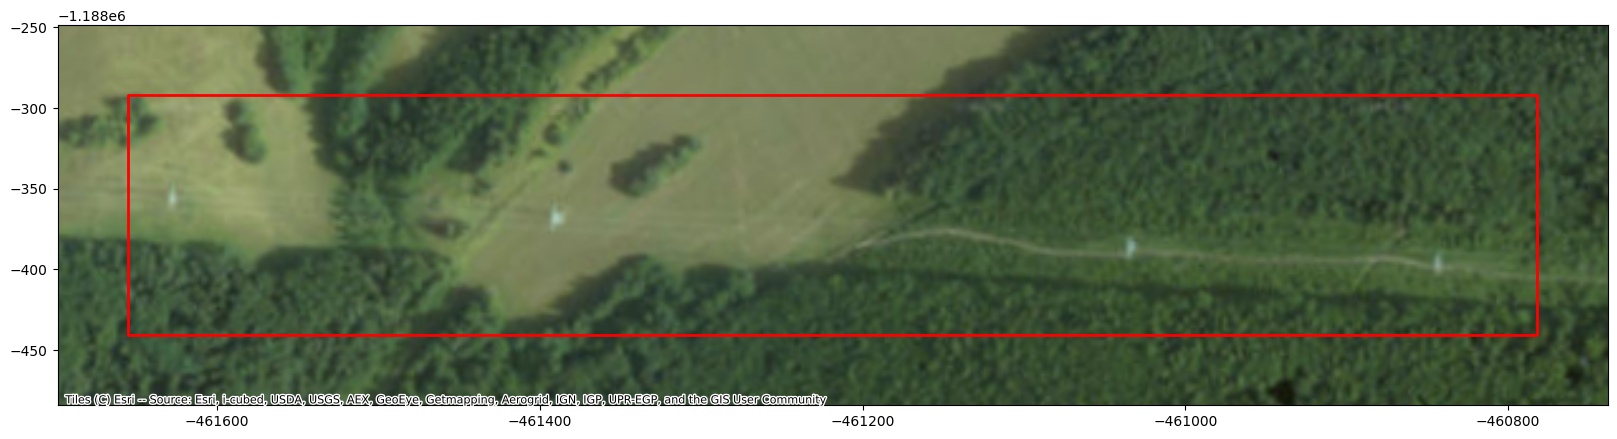

In [10]:
_ = plot_las_bounds(las_sampled.header, crs='EPSG:5514', basemap=True, scale=1.1)

## plot bounds of all the las files found

  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-30 13:04:34,763 - dicris - WARNING - could not read file '/tf/notebooks/data/Hyperspektral_data/HYSPED/02Let_05-09-2022/Klasifikovane_LAS/Pocarova 05-09-22.las': [Errno 13] Permission denied: '/tf/notebooks/data/Hyperspektral_data/HYSPED/02Let_05-09-2022/Klasifikovane_LAS/Pocarova 05-09-22.las'
2025-05-30 13:04:34,766 - dicris - WARNING - could not read file '/tf/notebooks/data/Hyperspektral_data/HYSPED/02Let_05-09-2022/Klasifikovane_LAS/Sverepec 05-09-22.las': [Errno 13] Permission denied: '/tf/notebooks/data/Hyperspektral_data/HYSPED/02Let_05-09-2022/Klasifikovane_LAS/Sverepec 05-09-22.las'
2025-05-30 13:04:34,768 - dicris - WARNING - could not read file '/tf/notebooks/data/Hyperspektral_data/HYSPED/02Let_05-09-2022/Klasifikovane_LAS/Visolaje 05-09-22.las': [Errno 13] Permission denied: '/tf/notebooks/data/Hyperspektral_data/HYSPED/02Let_05-09-2022/Klasifikovane_LAS/Visolaje 05-09-22.las'
2025-05-30 13:04:34,769 - dicris - WARNING - could not read file '/tf/notebooks/data/Hyp

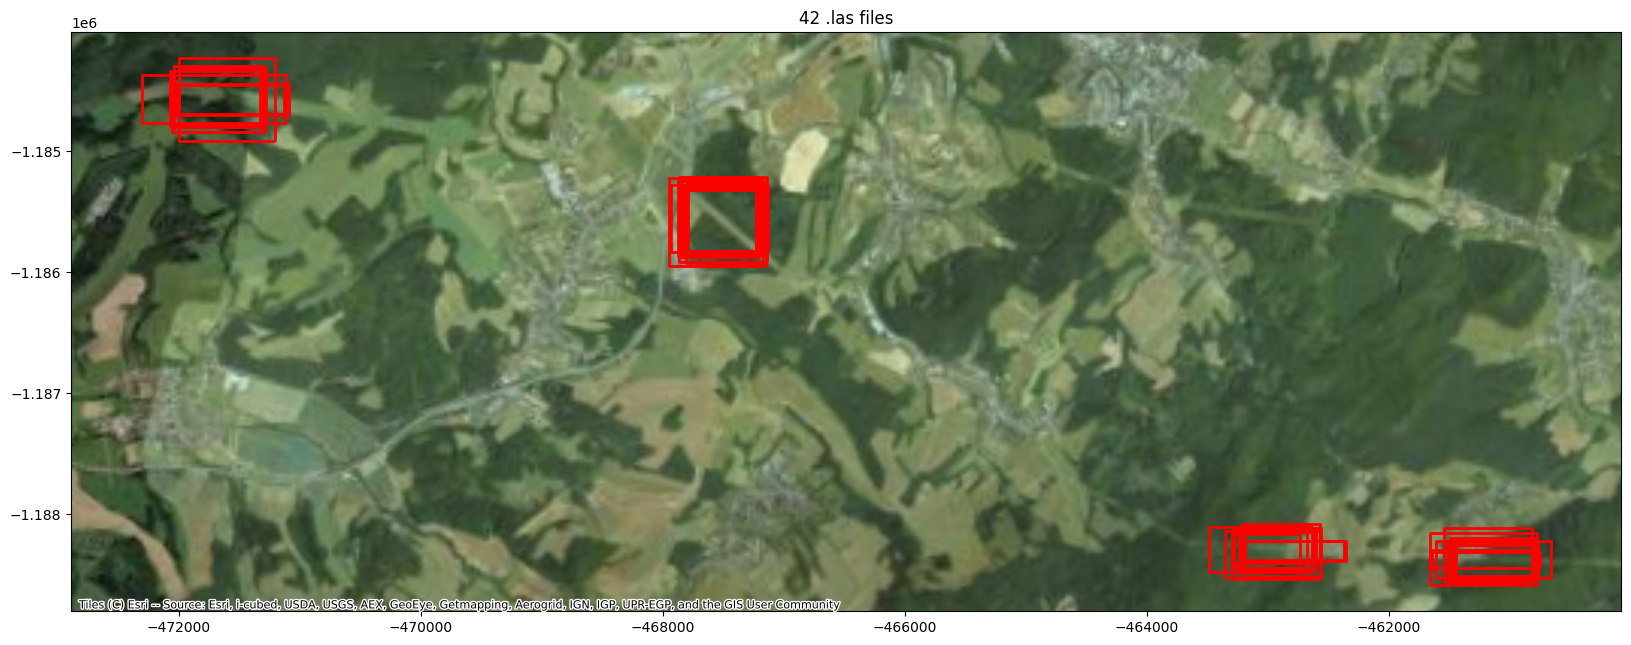

In [13]:
gdfs = gpd.GeoDataFrame()
errors = []
with tqdm(las_files) as pbar:
    for f in pbar:
        pbar.desc = f.name
        header = None
        try:
            with laspy.open(f, read_evlrs=False) as las_f:
                bbox = get_geographic_bounds_from_las_header(las_f.header)
                gdf_bounds = get_gdf_from_bounds(bbox, crs = 'EPSG:5514')
                gdfs = pd.concat([gdfs, gdf_bounds])
        except PermissionError as e:
            logger.warn(f'could not read file \'{f.as_posix()}\': {e}')
            errors.append(f)
    gdfs = gdfs.reset_index(drop=True)

_ = plot_gdf(gdfs, title=f'{len(gdfs)} .las files')

In [15]:
sorted([f.as_posix().lstrip('/tf/notebooks/data/') for f in errors])

['Hyperspektral_data/HYSPED/02Let_05-09-2022/Klasifikovane_LAS/Pocarova 05-09-22.las',
 'Hyperspektral_data/HYSPED/02Let_05-09-2022/Klasifikovane_LAS/Sverepec 05-09-22.las',
 'Hyperspektral_data/HYSPED/02Let_05-09-2022/Klasifikovane_LAS/Visolaje 05-09-22.las',
 'Hyperspektral_data/HYSPED/02Let_05-09-2022/Klasifikovane_LAS/Zavada 05-09-22.las',
 'Hyperspektral_data/HYSPED/04Let_13-09-2022/Klasifikovane_LAS/Pocarova 13-09-22.las',
 'Hyperspektral_data/HYSPED/04Let_13-09-2022/Klasifikovane_LAS/Sverepec 13-09-22.las',
 'Hyperspektral_data/HYSPED/04Let_13-09-2022/Klasifikovane_LAS/Visolaje 13-09-22.las',
 'Hyperspektral_data/HYSPED/04Let_13-09-2022/Klasifikovane_LAS/Zavada 13-09-22.las']